# Imports

In [1]:
import src.acquire
import src.prepare
import src.preprocessing
import src.model

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# Problem Statement | Background

# Acquire

In this section I'll go over how and where we're getting the data from

## Where the Data is Coming From

This data was provided by the Zillow team as part of a Kaggle competition. More information about the competition can be found here: https://www.kaggle.com/c/zillow-prize-1.

The data from the competition was saved to a mySQL database, which we'll pull into a pandas DataFrame to explore and model off of.

## How the Data is Being Filtered

Here I'll explain what we used to filter information through our SQL query:




# Fill this in!



In [2]:
# Reading in the data from the acquire.py into a dataframe
df = src.acquire.get_zillow_data()

CSV previously generated at `data/raw/zillow_unprocessed.csv`. Reading in that csv as a DataFrame


# Wrangle

## Handling Nulls

### Features Dropped

- What metric are we using to drop features? 
> *If a specific feature is missing more than 50 percent of it's values, we'll drop it*

- What metric are we using to drop rows? 
> *If a row is missing more than 75 percent of it's values, we'll drop it*

In [3]:
# Dropping features and rows with too many missing values
df = src.prepare.handle_missing_values(df)


    Number of rows dropped:    156
    Number of columns dropped: 34
    


> While this helped us get rid of a decent number of unusable observations (rows), this process helps us greatly reduce the number of insignificant features in our data.

### Filling Nulls with Median

> For each feature listed below, we'll be filling the null values with the median of the feature. 

> This in particular will help for these features at it will reduce the effect of outliers within the data.

```
Features
- taxvaluedollarcnt:            $358,880
- taxamount:                    $4448.72
- fullbathcnt:                  2 bathrooms
- lotsizesquarefeet:            7,205 sqft
- calculatedfinishedsquarefeet: 1,542 sqft
- structuretaxvaluedollarcnt:   $136,389
- finishedsquarefeet12          1,523 sqft
```

In [4]:
df = src.prepare.fill_nulls_with_median(df)

### Filling Nulls with Mode

> For each feature listed below, we'll be filling the null values with the mode of the feature. 

```
Features
- regionidzip:           97319
- regionidcity:          12447
- yearbuilt:             1955
- landtaxvaluedollarcnt: $21,299
- lotsizesquarefeet:     6,000 sqft   
```

In [5]:
df = src.prepare.fill_nulls_with_mode(df)

In [6]:
mode = df.yearbuilt.mode()
df.yearbuilt.fillna(mode)

0        1998.0
1        1967.0
2        1962.0
3        1970.0
4        1964.0
          ...  
77570    1940.0
77571    1964.0
77572    1954.0
77573    1955.0
77574    1960.0
Name: yearbuilt, Length: 77419, dtype: float64

In [7]:
df.yearbuilt.isna().sum()

114

## Dropping Columns

Even though we've created a threshold to drop columns based on missing values, there's still some columns we should drop to clean up the dataframe:

```
Columns to Drop
- buildingqualitytypeid  -|
- heatingorsystemtypeid   | --> These features were used to merge in mySQL
- propertylandusetypeid  -|

- propertycountylandusecode: We've already filtered for single unit residents
- propertyzoningdesc:  Irrelevant data
- censustractandblock: Too many missing values
- Unnamed: 0: Remnant of reading from a csv
```

In [8]:
# Dropping columns
df = src.prepare.drop_columns(df)

# Exploration

Our FIPs feature is the most useful for identifying which counties are in our data, so we'll convert the feature to reflect those names. 

> An issue came up later in modeling, so making sure this feature is only changed during explorataion.

In [9]:
explore_df = df.copy()

In [10]:
# Convert fips to county name, use https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt
explore_df.fips = explore_df.fips.replace({6037.0:'Los_Angeles_County', 6059.0:'Orange_County', 6111.0:'Ventura_County'})

## Splitting the Data

In [11]:
ex_train, ex_test, ex_validate = src.preprocessing.split_data(explore_df)

## Scaling

In [12]:
# Converting the selected features to 'object' types to preserve them
for dataframe in [ex_train, ex_test, ex_validate]:
    src.prepare.numeric_to_object(dataframe)

In [13]:
# Scale the data
for dataframe in [ex_train, ex_test, ex_validate]:
    src.preprocessing.scale_data(dataframe)

## Correlation Testing

Make your titles and labels meaningful, make your number formats friendly to the end user.

### Looking at Correlation By County

In [14]:
# Let's chart out a subset of columns for now, so the charts run in a decent amount of time
ex_df = ex_train[["bathroomcnt", "bedroomcnt", "lotsizesquarefeet", "yearbuilt", "calculatedfinishedsquarefeet", "taxamount", "taxvaluedollarcnt", "logerror", "fips", "longitude", "latitude", "regionidzip"]]

In [15]:
# sns.pairplot(ex_df, hue='fips')

In [16]:
# sns.heatmap(ex_df.corr(), cmap='RdYlBu', annot=True, center=0)

A correlation between number of bedrooms and number of bathrooms makes sense, as well as a correlation between longitude and latitude. 
> We can make a feature to combine bathroom and bedroom count

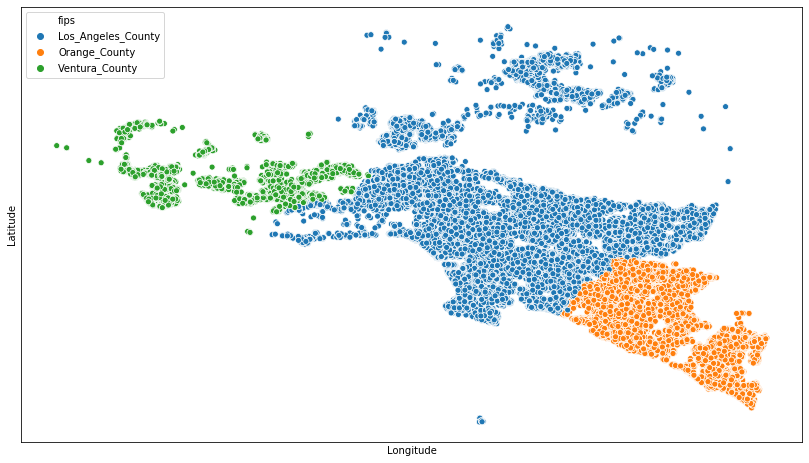

In [17]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='fips', data=ex_df)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Modeling

In [18]:
# Conserving Dtypes
df = src.prepare.numeric_to_object(df)

## Split and Scale the Data 

In [19]:
train, test, validate = src.preprocessing.split_scale_data(df)

In [21]:
X = ["bathroomcnt", 
     "bedroomcnt", 
     "lotsizesquarefeet",
     "calculatedfinishedsquarefeet", 
     "taxamount", 
     "taxvaluedollarcnt",  
     "fips",
     "longitude", 
     "latitude"]

X_train = train[X]

In [22]:
X_train.dtypes

bathroomcnt                     float64
bedroomcnt                      float64
lotsizesquarefeet               float64
calculatedfinishedsquarefeet    float64
taxamount                       float64
taxvaluedollarcnt               float64
dtype: object

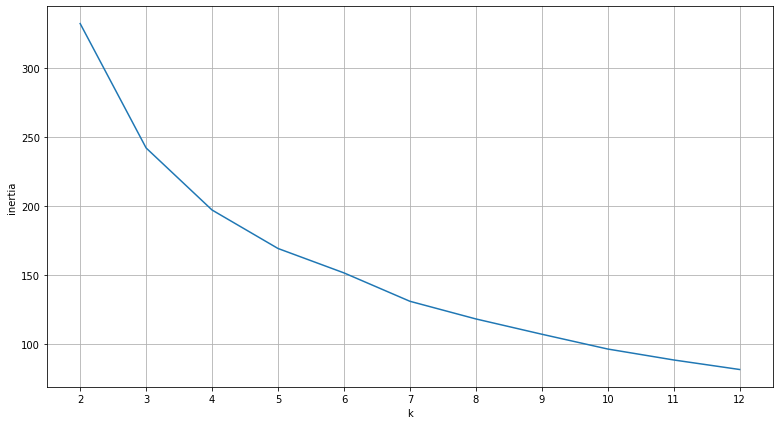

In [23]:
src.model.plot_inertia(X_train)

# Evaluation

# Conclusion